In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime, timedelta

ModuleNotFoundError: No module named 'boto3'

In [3]:
import netCDF4 as nc

In [4]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))


In [5]:
day_of_year = datetime.utcnow().timetuple().tm_yday
curr_hr = datetime.utcnow().timetuple().tm_hour
curr_file = s3.list_objects(Bucket='noaa-goes16', Prefix='ABI-L2-MCMIPM/2017/{doy}/{hr:02d}/OR_ABI-L2-MCMIPM1'
                           .format(doy=day_of_year, hr=curr_hr))['Contents'][-1]
filnm = curr_file['Key'].split('/')[-1]
s3.download_file('noaa-goes16', curr_file['Key'], '/tmp/'+filnm)



In [19]:
'ABI-L2-MCMIPM/2017/{doy}/{hr:02d}/'.format(doy=day_of_year, hr=curr_hr)

'ABI-L2-MCMIPM/2017/253/03/'

In [ ]:
curr_file['Key']

In [ ]:
goesrfil = nc.Dataset("/tmp/goesr.nc")

In [ ]:
goesrfil

In [ ]:
imshow(goesrfil.variables['Rad'])

In [ ]:
np.array(goesrfil.variables['y_image_bounds'])[0]/37.2302

In [ ]:
np.array(goesrfil.variables['y_image_bounds'])[1]/25.5906

In [ ]:
np.array(goesrfil.variables['y_image_bounds'])*5434894.885056

In [ ]:
(np.array(goesrfil.variables['y_image_bounds']))*180/np.pi

In [ ]:
np.array(goesrfil.variables['x_image_bounds'])*5434894.885056

In [ ]:
sat = pyproj.Proj('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027 +lat_0=0.0 +lon_0=-89.5 +sweep=x +no_defs')
x,y =  sat( goesrfil['geospatial_lat_lon_extent'].geospatial_westbound_longitude,
           goesrfil['geospatial_lat_lon_extent'].geospatial_northbound_latitude, radians = False, errcheck = True)
x2, y2 =   sat( goesrfil['geospatial_lat_lon_extent'].geospatial_eastbound_longitude,
           goesrfil['geospatial_lat_lon_extent'].geospatial_southbound_latitude, radians = False, errcheck = True)

In [ ]:
x,y

In [ ]:
x2, y2

In [ ]:
 goesrfil['geospatial_lat_lon_extent'].geospatial_westbound_longitude

In [ ]:
curr_file['Key']

In [ ]:
curr_file

In [ ]:
s3.list_objects(Bucket='noaa-goes16', Prefix='ABI-L1b-RadC/2017/237/')

In [ ]:
s3r = boto3.resource('s3')

In [ ]:
s3r.Bucket("noaa-goes16").get_available_subresources()

In [ ]:
import satpy
from datetime import datetime

In [ ]:
filnm[44:58]

In [ ]:
sarttim = datetime.strptime(filnm[28:42], "%Y%j%H%M%S%f")
endtim = datetime.strptime(filnm[44:58], "%Y%j%H%M%S%f")

In [ ]:
goesscn = satpy.Scene(filenames=["/tmp/"+filnm], reader="abi_l1b", start_time=sarttim, end_time=endtim)

In [ ]:
goesscn.available_dataset_names()

In [ ]:
goesscn.load(['C16'])

In [ ]:
goesscn.show("C16")

In [ ]:
goesscn.resample()

In [ ]:
goesrfil2 = nc.Dataset("/tmp/channel16_r.nc")

In [ ]:
goesrfil2

In [ ]:
lons, lats = np.meshgrid(np.array(goesrfil2.variables['lon']),np.array(goesrfil2.variables['lat']))

In [ ]:
imshow(np.array(goesrfil2.variables['Band1']))

In [ ]:
contourf(lons, lats, np.array(goesrfil2.variables['Band1']))

In [ ]:
np.array(goesrfil2.variables['Band1'])

In [ ]:
goesrfil_current = nc.Dataset("/tmp/"+filnm)

In [ ]:
filnm

In [ ]:
np.array(goesrfil_current['y_image_bounds'])

In [ ]:
goesrfil_current.variables['geospatial_lat_lon_extent']

In [ ]:
np.array(goesrfil_current['y_image'])

In [ ]:
from osgeo import osr
from osgeo import gdal


In [ ]:
KM_PER_DEGREE = 111.32
 
# GOES-16 Extent (satellite projection) [llx, lly, urx, ury]
GOES16_EXTENT = [-5434894.885056, -5434894.885056, 5434894.885056, 5434894.885056]


In [ ]:
sourcePrj = osr.SpatialReference()
sourcePrj.ImportFromProj4('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027 +lat_0=0.0 +lon_0=-89.5 +sweep=x +no_defs')
 
# Lat/lon WSG84 Spatial Reference System
targetPrj = osr.SpatialReference()
targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')


In [ ]:
def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
def getScaleOffset(path):
    nc = Dataset(path, mode='r')
    scale = nc.variables['CMI'].scale_factor
    offset = nc.variables['CMI'].add_offset
    nc.close()
    return scale, offset


In [ ]:
def remap(path, extent, resolution, driver):
     
    # Read scale/offset from file
    scale, offset = getScaleOffset(path)
     
    # Build connection info based on given driver name
    if(driver == 'NETCDF'):
        connectionInfo = 'NETCDF:\"' + path + '\":Rad'
    else: # HDF5
        connectionInfo = 'HDF5:\"' + path + '\"://Rad'
         
    # Open NetCDF file (GOES-16 data)  
    raw = gdal.Open(connectionInfo, gdal.GA_ReadOnly)
    
    # Setup projection and geo-transformation
    raw.SetProjection(sourcePrj.ExportToWkt())
    raw.SetGeoTransform(getGeoT(GOES16_EXTENT, raw.RasterYSize, raw.RasterXSize))
         
    # Compute grid dimension
    sizex = int(((extent[2] - extent[0]) * KM_PER_DEGREE) / resolution)
    sizey = int(((extent[3] - extent[1]) * KM_PER_DEGREE) / resolution)
     
    # Get memory driver
    memDriver = gdal.GetDriverByName('MEM')
    
    # Create grid
    grid = memDriver.Create('grid', sizex, sizey, 1, gdal.GDT_Float32)
     
    # Setup projection and geo-transformation
    grid.SetProjection(targetPrj.ExportToWkt())
    grid.SetGeoTransform(getGeoT(extent, grid.RasterYSize, grid.RasterXSize))
 
    # Perform the projection/resampling 
 
    print ('Remapping', path)
         
    start = t.time()
     
    gdal.ReprojectImage(raw, grid, sourcePrj.ExportToWkt(), targetPrj.ExportToWkt(), gdal.GRA_NearestNeighbour, options=['NUM_THREADS=ALL_CPUS']) 
     
    print ('- finished! Time:', t.time() - start, 'seconds')
     
    # Close file
    raw = None
         
    # Read grid data
    array = grid.ReadAsArray()
     
    # Mask fill values (i.e. invalid values)
    np.ma.masked_where(array, array == -1, False)
     
    # Apply scale and offset
    array = array * scale + offset
     
    grid.GetRasterBand(1).SetNoDataValue(-1)
    grid.GetRasterBand(1).WriteArray(array)
 
    return grid

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
 
from netCDF4 import Dataset
import numpy as np
from osgeo import osr
from osgeo import gdal
import time as t
 
# Define KM_PER_DEGREE
KM_PER_DEGREE = 111.32
 
# GOES-16 Extent (satellite projection) [llx, lly, urx, ury]
GOES16_EXTENT = [-5434894.885056, -5434894.885056, 5434894.885056, 5434894.885056]
 
# GOES-16 Spatial Reference System
sourcePrj = osr.SpatialReference()
sourcePrj.ImportFromProj4('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414 +f=0.00335281068119356027 +lat_0=0.0 +lon_0=-89.5 +sweep=x +no_defs')
 
# Lat/lon WSG84 Spatial Reference System
targetPrj = osr.SpatialReference()
targetPrj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
 
def getGeoT(extent, nlines, ncols):
    # Compute resolution based on data dimension
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
def getScaleOffset(path):
    nc = Dataset(path, mode='r')
    scale = nc.variables['CMI'].scale_factor
    offset = nc.variables['CMI'].add_offset
    nc.close()
    return scale, offset
     
def remap(path, extent, resolution, driver):
     
    # Read scale/offset from file
    scale, offset = getScaleOffset(path)
     
    # Build connection info based on given driver name
    if(driver == 'NETCDF'):
        connectionInfo = 'NETCDF:\"' + path + '\":CMI'
    else: # HDF5
        connectionInfo = 'HDF5:\"' + path + '\"://CMI'
         
    # Open NetCDF file (GOES-16 data)  
    raw = gdal.Open(connectionInfo, gdal.GA_ReadOnly)
    
    # Setup projection and geo-transformation
    raw.SetProjection(sourcePrj.ExportToWkt())
    raw.SetGeoTransform(getGeoT(GOES16_EXTENT, raw.RasterYSize, raw.RasterXSize))
         
    # Compute grid dimension
    sizex = int(((extent[2] - extent[0]) * KM_PER_DEGREE) / resolution)
    sizey = int(((extent[3] - extent[1]) * KM_PER_DEGREE) / resolution)
     
    # Get memory driver
    memDriver = gdal.GetDriverByName('MEM')
    
    # Create grid
    grid = memDriver.Create('grid', sizex, sizey, 1, gdal.GDT_Float32)
     
    # Setup projection and geo-transformation
    grid.SetProjection(targetPrj.ExportToWkt())
    grid.SetGeoTransform(getGeoT(extent, grid.RasterYSize, grid.RasterXSize))
 
    # Perform the projection/resampling 
 
    print ('Remapping', path)
         
    start = t.time()
     
    gdal.ReprojectImage(raw, grid, sourcePrj.ExportToWkt(), targetPrj.ExportToWkt(), gdal.GRA_NearestNeighbour, options=['NUM_THREADS=ALL_CPUS']) 
     
    print ('- finished! Time:', t.time() - start, 'seconds')
     
    # Close file
    raw = None
         
    # Read grid data
    array = grid.ReadAsArray()
     
    # Mask fill values (i.e. invalid values)
    np.ma.masked_where(array, array == -1, False)
     
    # Apply scale and offset
    array = array * scale + offset
     
    grid.GetRasterBand(1).SetNoDataValue(-1)
    grid.GetRasterBand(1).WriteArray(array)
 
    return grid

In [6]:
cmipfil = nc.Dataset("/tmp/OR_ABI-L2-CMIPM2-M3C16_G16_s20172432215530_e20172432215599_c20172432216046.nc")

RuntimeError: No such file or directory

In [4]:
mcmipfil = nc.Dataset("/tmp/OR_ABI-L2-MCMIPM1-M3_G16_s20172531902245_e20172531902302_c20172531902377.nc")

In [ ]:
mcmipfil

In [11]:
import pyproj

In [12]:
sat = pyproj.Proj('+proj=geos +h=35786023.0 +a=6378137.0 +b=6356752.31414  +lat_0=0.0 +lon_0=-89.5 +sweep=x +no_defs')
x,y =  sat( mcmipfil['geospatial_lat_lon_extent'].geospatial_westbound_longitude,
           mcmipfil['geospatial_lat_lon_extent'].geospatial_northbound_latitude, radians = False, errcheck = True)
x2, y2 =   sat( mcmipfil['geospatial_lat_lon_extent'].geospatial_eastbound_longitude,
           mcmipfil['geospatial_lat_lon_extent'].geospatial_southbound_latitude, radians = False, errcheck = True)

In [13]:
import pyproj

In [14]:
x, y, x2, y2

(-2424610.4576570503,
 4047864.4704382196,
 -1423102.4732995569,
 3046356.709762922)

In [15]:
cmipfil['geospatial_lat_lon_extent'].geospatial_eastbound_longitude

NameError: name 'cmipfil' is not defined

In [16]:
test_ll_fil = nc.Dataset("/tmp/channel16_r.nc")

OSError: No such file or directory

In [ ]:
lons, lats = np.meshgrid(np.array(test_ll_fil.variables['lon']),np.array(test_ll_fil.variables['lat']))

In [ ]:
contourf(lons, lats, np.array(test_ll_fil.variables['Band1']))

In [5]:
test_ll_fil_c01 = nc.Dataset("/tmp/channel01_r.nc")
test_ll_fil_c02 = nc.Dataset("/tmp/channel02_r.nc")
test_ll_fil_c03 = nc.Dataset("/tmp/channel03_r.nc")

OSError: No such file or directory

In [103]:
mcmipfil

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v25, 05 July 2013)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-Test
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Mesoscale
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-MCMIPM1-M3_G16_s20172531902245_e20172531902302_c20172531902377.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
  

In [9]:
ref_1 = mcmipfil['CMI_C01']
ref_2 = mcmipfil['CMI_C02']
ref_3 = mcmipfil['CMI_C03']

In [19]:
np.normalize(ref_1)

AttributeError: module 'numpy' has no attribute 'normalize'

In [26]:
ref_gamma_1 = np.sqrt(ref_1/np.max(ref_1))
ref_gamma_2 = np.sqrt(ref_2/np.max(ref_2))
ref_gamma_3 = np.sqrt(ref_3/np.max(ref_3))
ref_gamma_true_green = 0.48358168 * ref_gamma_2 + 0.45706946 * ref_gamma_1 + 0.06038137 * ref_gamma_3


In [5]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE


In [28]:

truecolor = np.stack([ref_gamma_2, ref_gamma_true_green, ref_gamma_1], axis=2)
img_extent = (mcmipfil['geospatial_lat_lon_extent'].geospatial_westbound_longitude, 
              mcmipfil['geospatial_lat_lon_extent'].geospatial_eastbound_longitude,
              mcmipfil['geospatial_lat_lon_extent'].geospatial_southbound_latitude,
              mcmipfil['geospatial_lat_lon_extent'].geospatial_northbound_latitude,)

In [46]:
mcmipfil['geospatial_lat_lon_extent']

<class 'netCDF4._netCDF4.Variable'>
float32 geospatial_lat_lon_extent()
    geospatial_westbound_longitude: -123.773
    geospatial_northbound_latitude: 43.3205
    geospatial_eastbound_longitude: -104.877
    geospatial_southbound_latitude: 29.7028
    geospatial_lat_center: 35.905
    geospatial_lon_center: -112.521
    geospatial_lat_nadir: 0.0
    geospatial_lon_nadir: -89.5
    geospatial_lat_units: degrees_north
    geospatial_lon_units: degrees_east
    long_name: geospatial latitude and longitude references
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used

In [53]:
mcmipfil['goes_imager_projection']

<class 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -89.5
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [56]:
35786023.0/1000+6378

42164.023

In [11]:
#code to convert to lat lon from the GOES FGF
R_POL = 6356.7523
R_EQ  = 6378.1370
F = 1.0/298.257222101
FP = 1.0/((1.0-F)*(1.0-F))
H_MSG = 42164.023
H_GOESR = 42164.023
RAD_TO_DEG = 180/np.pi
'''
Input:
fgf_x: fractional FGF coordinate, zero-based
fgf_y: fractional FGF coordinate, zero-based
 * @param[in] scale_x scaleFactor from the x coordinate variable
 * @param[in] offset_x addOffset from the x coordinate variable
 * @param[in] scale_y scaleFactor from the y coordinate variable
 * @param[in] offset_y addOffset from the y coordinate variable
 * @param[out] lamda units: radians
 * @param[out] theta units: radians

'''
def fgf_to_sat_abi(fgf_x, fgf_y, scale_x, offset_x, scale_y, offset_y):
    lamda = fgf_x * scale_x + offset_x
    theta = fgf_y * scale_y + offset_y
    return (lamda, theta)

def goes_to_geos(lamda, theta):
    theta_geos = np.arcsin(np.sin(theta) * np.cos(lamda))
    lamda_geos = np.arctan(np.tan(lamda)/np.cos(theta))
    return lamda_geos, theta_geos

def sat_to_earth(lamda, theta, sub_lon_degrees):
    
    sub_lon_radians = sub_lon_degrees * np.pi/180.0
    
    h = H_MSG
    x, y = goes_to_geos(lamda, theta)
    
    d = h*h - R_EQ*R_EQ
    c1 = (h*np.cos(x) * np.cos(y)) * (h * np.cos(x) * np.cos(y))
    c2 = (np.cos(y) * np.cos(y) + FP * np.sin(y)*np.sin(y))*d
    
    
    s_d = np.sqrt(c1-c2)
    
    s_n = (h* np.cos(x) * np.cos(y) - s_d)/ (np.cos(y)*np.cos(y) +
                                            FP * np.sin(y) * np.sin(y))
    s_1 = h-s_n * np.cos(x) * np.cos(y)
    s_2 = s_n * np.sin(x) * np.cos(y)
    s_3 = -s_n * np.sin(y)
    
    s_xy = np.sqrt(s_1*s_1 + s_2*s_2)
    
    geographic_lon = np.arctan(s_2/s_1) + sub_lon_radians
    
    geographic_lat = np.arctan(-FP*(s_3/s_xy))
    
    lon_degrees = RAD_TO_DEG * geographic_lon
    lat_degrees = RAD_TO_DEG * geographic_lat
    
    return lon_degrees, lat_degrees


In [ ]:
for x in 

In [129]:
lons, lats = np.meshgrid([1,2,3,4], [5,6,7,8])

In [26]:
import os
os.listdir("/tmp/")

['com.apple.launchd.e8sxT9yAGA',
 'com.apple.launchd.Scn79ulgIn',
 'com.apple.launchd.vvZjWWOHrC',
 'OR_ABI-L2-MCMIPM2-M3_G16_s20172530312546_e20172530313003_c20172530313070.nc',
 'wifi-09-08-2017__17:56:31.log',
 'wifi-09-08-2017__17:56:41.log']

In [29]:
nc.Dataset("/tmp/")

RuntimeError: NetCDF: Unknown file format

In [51]:
g16 =nc.Dataset("/tmp/OR_ABI-L2-MCMIPM1-M3_G16_s20172530335246_e20172530335303_c20172530335372.nc")

In [42]:
g16

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v25, 05 July 2013)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-Test
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Mesoscale
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-MCMIPM2-M3_G16_s20172530312546_e20172530313003_c20172530313070.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
  

In [ ]:
for x in g16['x']

In [35]:
g16['geospatial_lat_lon_extent']

<class 'netCDF4._netCDF4.Variable'>
float32 geospatial_lat_lon_extent()
    geospatial_westbound_longitude: -125.36
    geospatial_northbound_latitude: 42.2671
    geospatial_eastbound_longitude: -106.285
    geospatial_southbound_latitude: 28.8376
    geospatial_lat_center: 34.9681
    geospatial_lon_center: -114.001
    geospatial_lat_nadir: 0.0
    geospatial_lon_nadir: -89.5
    geospatial_lat_units: degrees_north
    geospatial_lon_units: degrees_east
    long_name: geospatial latitude and longitude references
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used

In [53]:
lons, lats = sat_to_earth(g16['x'], g16['y'], -89.5)


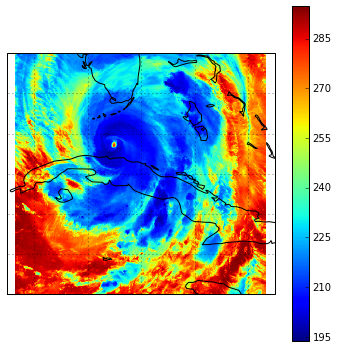

In [63]:
lls, las = np.meshgrid(lons, lats)
fig = plt.figure(figsize=(6,6),dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-85, -75, 18, 27], ccrs.Geodetic())

x = ax.pcolormesh(lls, las,g16['CMI_C13'], transform=ccrs.PlateCarree())
plt.colorbar(x)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines()

plt.show()



In [6]:
g16_day = nc.Dataset("/tmp/OR_ABI-L2-MCMIPM2-M3_G16_s20172521759548_e20172521800007_c20172521800078.nc")

In [7]:
g16_day

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v25, 05 July 2013)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-Test
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Mesoscale
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-MCMIPM2-M3_G16_s20172521759548_e20172521800007_c20172521800078.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
  

In [14]:
lonlats = list()
xpts= 
for xpt in g16_day['x']:
    for ypt in g16_day['y']:
        lonlats.append(tuple(sat_to_earth(xpt, ypt, -89.5)))

In [15]:
lsma = np.array(lonlats)

In [16]:
lsma = np.array(lonlats)
lons22  = lsma[:,0]
lats22  = lsma[:,1]
lons22= lons22.reshape((500,500))
lats22= lats22.reshape((500,500))


In [76]:
origxpts = list(g16_day['x'])
origypts = list(g16_day['y'])
grad = (np.gradient(list(g16_day['x'])))

origxpts.append(origxpts[-1]+np.mean(grad))
newxpts = np.array(origxpts)-(np.mean(grad)/2.0)
grady = (np.gradient(list(g16_day['y'])))

origypts.append(origypts[-1]+np.mean(grady))
newypts = np.array(origypts)-(np.mean(grad)/2.0)


In [77]:
lonlats = np.zeros((np.shape(newxpts)[0]*np.shape(newypts)[0], 2))
lonlats = list()
for xpt in newxpts:
    for ypt in newypts:
        #lontemp, lattemp = sat_to_earth(xpt, ypt, -89.5)
        lonlats.append(tuple(sat_to_earth(xpt, ypt, -89.5)))

In [79]:
lsma = np.array(lonlats)
lons22  = lsma[:,0]
lats22  = lsma[:,1]
lons22= lons22.reshape((501,501))
lats22= lats22.reshape((501,501))


In [111]:
xx_mg, yy_mg = np.meshgrid(newxpts, newypts)
lons_meshgridtest, lats_meshgridtest = sat_to_earth(xx_mg, yy_mg, -89.5)

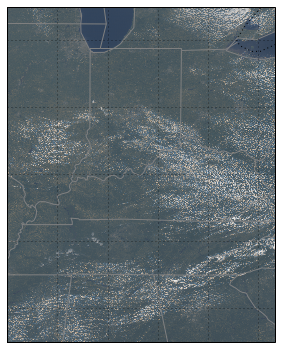

In [109]:
lons2, lats2 = sat_to_earth(g16_day['x'], g16_day['y'], -89.5)

ref_gamma_1 = np.sqrt(g16_day['CMI_C01']/np.max(g16_day['CMI_C01']))
ref_gamma_2 = np.sqrt(g16_day['CMI_C02']/np.max(g16_day['CMI_C02']))
ref_gamma_3 = np.sqrt(g16_day['CMI_C03']/np.max(g16_day['CMI_C03']))
ref_gamma_true_green = 0.48358168 * ref_gamma_2 + 0.45706946 * ref_gamma_1 + 0.06038137 * ref_gamma_3
ref_gamma_true_green = ref_gamma_true_green/np.max(ref_gamma_true_green)
rgb_arr = np.array([ref_gamma_2.flatten('F'), ref_gamma_true_green.flatten('F'), ref_gamma_1.flatten('F'),
                   np.ones(np.shape(ref_gamma_1.flatten("F")))]).transpose()
truecolor = np.stack([ref_gamma_2, ref_gamma_true_green, ref_gamma_1], axis=2)
states = NaturalEarthFeature(category='cultural',
                                    name='admin_1_states_provinces_lines',
                                    scale='50m', facecolor='none')

lls, las = np.meshgrid(lons2, lats2)
fig = plt.figure(figsize=(6,6),dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -82,33, 43], ccrs.Geodetic())
_ = ax.add_feature(states, edgecolor='gray')
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN, facecolor=None)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, facecolor="None", edgecolor='gray')
rgb_arr = np.swapaxes(rgb_arr.reshape((500,500,4)),0,1).reshape((250000,4))

#x = ax.imshow(truecolor, extent=(np.min(lons2), np.max(lons2), np.min(lats2), np.max(lats2)), transform=ccrs.PlateCarree(), origin='upper')
x = ax.pcolormesh(lons22.T, lats22.T,ref_gamma_3,color=rgb_arr, transform=ccrs.PlateCarree())
# color=rgb_arr,
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines()

plt.show()



In [85]:
lons22.T[0]

array([-92.67411792, -92.64773463, -92.62133535, -92.59495298,
       -92.56857046, -92.54218826, -92.51580615, -92.48942438,
       -92.46302794, -92.43666242, -92.41028215, -92.38390204,
       -92.35752188, -92.33114235, -92.30476365, -92.27839923,
       -92.25202082, -92.22565687, -92.1992788 , -92.17291537,
       -92.14653876, -92.12017589, -92.09381312, -92.06745093,
       -92.04107531, -92.01471334, -91.98835208, -91.9619907 ,
       -91.93562937, -91.90926878, -91.88290833, -91.85656006,
       -91.83020032, -91.80384055, -91.77749284, -91.75113427,
       -91.72477532, -91.69842848, -91.67208153, -91.64572376,
       -91.61937742, -91.5930313 , -91.56667417, -91.54032857,
       -91.51398274, -91.48763698, -91.46129167, -91.43494697,
       -91.40860229, -91.38225774, -91.355923  , -91.32957857,
       -91.3032351 , -91.27690046, -91.25055726, -91.22421425,
       -91.19788017, -91.17154607, -91.14520386, -91.11887035,
       -91.09253704, -91.06619561, -91.03986227, -91.01

In [77]:
lons_single = np.array(lonlats)[:,0]
lats_single = np.array(lonlats)[:,1]

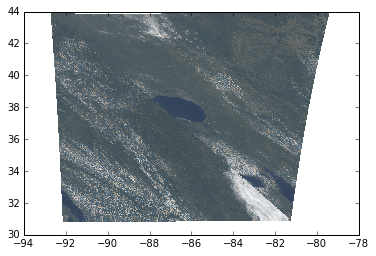

In [82]:
rgb_arr = np.array([ref_gamma_2.flatten('F'), ref_gamma_true_green.flatten('F'), ref_gamma_1.flatten('F')]).transpose()
rgb_arr = np.swapaxes(rgb_arr.reshape((500,500,3)),0,1).reshape((250000,3))
pcolormesh(lons22.T[:-1,:-1], lats22.T[:-1,:-1],,color=rgb_arr)

In [68]:
rgb_arr[230*500+499]

array([ 0.2495417 ,  0.31189784,  0.3455632 ], dtype=float32)

In [69]:
ref_gamma_2[-1,230]

0.2495417

AttributeError: 'tuple' object has no attribute 'transpose'

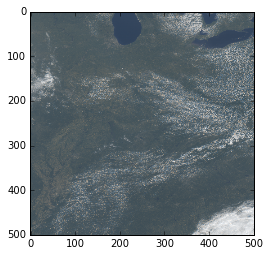

In [18]:
imshow(np.swapaxes(rgb_arr.reshape((500,500,3)),0,1))

In [39]:
np.shape(rgb_arr)

(250000, 3)

In [37]:
x = [1,2,3,4,5]
x[:-1]

[1, 2, 3, 4]

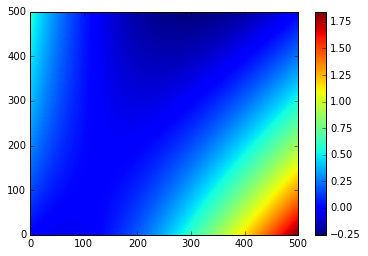

In [25]:
pcolormesh(lons22.T-lls)
plt.colorbar()

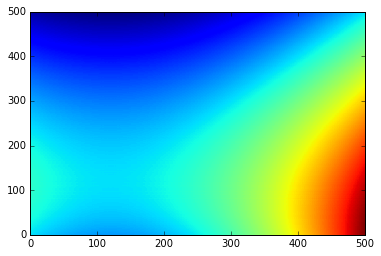

In [26]:
pcolormesh(lats22.T-las)

In [ ]:
plt.

In [159]:
np.shape(ref_gamma_1)

(500, 500)

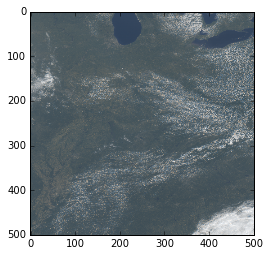

In [142]:
imshow(truecolor)

In [ ]:
lls

In [92]:
import matplotlib.patches as patches


In [ ]:
n

In [79]:
lons

array([-84.68214417, -84.66226196, -84.64242554, -84.62258148,
       -84.6027298 , -84.58289337, -84.56308746, -84.5432663 ,
       -84.52346039, -84.50366211, -84.48389435, -84.46407318,
       -84.44431305, -84.4245224 , -84.40476227, -84.3850174 ,
       -84.36528015, -84.34555054, -84.32579803, -84.30607605,
       -84.28635406, -84.26663971, -84.24692535, -84.227211  ,
       -84.20754242, -84.18782043, -84.16819   , -84.14850616,
       -84.12884521, -84.10917664, -84.08953094, -84.06989288,
       -84.05026245, -84.03065491, -84.01102448, -83.99139404,
       -83.97182465, -83.95220184, -83.93260193, -83.9129715 ,
       -83.89341736, -83.8738327 , -83.85430145, -83.83473206,
       -83.81517792, -83.79560852, -83.77603149, -83.75653839,
       -83.73703003, -83.71748352, -83.69799805, -83.67845154,
       -83.65896606, -83.6394577 , -83.61994934, -83.60050201,
       -83.58098602, -83.56151581, -83.54211426, -83.52265167,
       -83.50317383, -83.4837265 , -83.46429443, -83.44

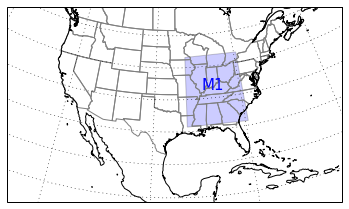

In [102]:
fig = plt.figure(figsize=(6,6),dpi=200)
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-126, -65, 15, 50], ccrs.Geodetic())
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
#ax.scatter(lons22.T, lats22.T, transform=ccrs.PlateCarree())
#x = ax.scatter(lls, las,transform=ccrs.PlateCarree())

ax.add_patch(
      patches.Rectangle(
        (np.min(lons22), np.min(lats22)),
        np.max(lons22) -np.min(lons22),
        np.max(lats22) -np.min(lats22),
        facecolor='blue',
        alpha=0.2,
        transform=ccrs.PlateCarree()    )
)
ax.text(np.mean(lons22), np.mean(lats22), 'M1',
        verticalalignment='bottom', horizontalalignment='center',
        transform=ccrs.PlateCarree(),
        color='blue', fontsize=15)


ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines()

plt.show()



In [31]:
img_extent

(-123.77316, -104.87663, 29.702766, 43.320518)

In [33]:
mcmipfil['geospatial_lat_lon_extent'].geospatial_eastbound_longitude

-104.87663

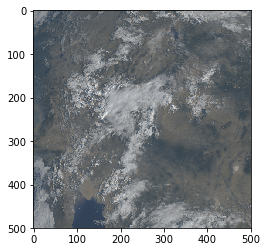

In [36]:
imshow(truecolor)

/Users/sfreeman/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sfreeman/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sfreeman/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


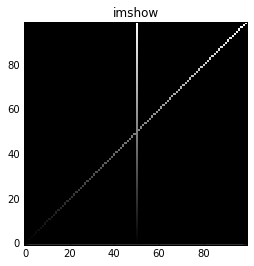

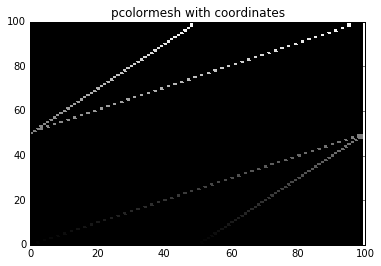

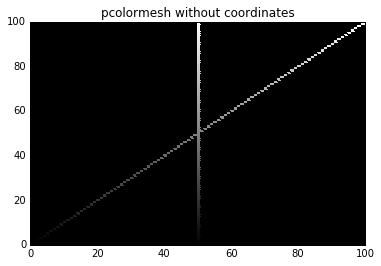

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Define coordinate arrays
N = 100
x = np.arange(N)
y = np.arange(N)
x, y = np.meshgrid(x, y)

# Define RGB arrays
r = np.zeros(x.shape)
g = np.zeros(x.shape)
b = np.zeros(x.shape)

# ... brush along the diagonal
r[range(N), range(N)] = np.linspace(0, 1, N)
g[range(N), range(N)] = np.linspace(0, 1, N)
b[range(N), range(N)] = np.linspace(0, 1, N)

# ... brush vertically
r[:, N/2.0] = np.linspace(0, 1, N)
g[:, N/2.0] = np.linspace(0, 1, N)
b[:, N/2.0] = np.linspace(0, 1, N)

# ... Stack them
rgb = np.dstack([r, g, b])

# Reshape as list of rgb tuples
color_tuples = np.array([r.flatten(), g.flatten(), b.flatten()]).transpose()
# Plot using imshow
plt.figure()
plt.imshow(rgb, origin='lower', interpolation='none')
plt.title('imshow')

# Plot using pcolormesh (with coordinates)
plt.figure()
numtoskip = (np.shape(x)[0]-1)**2-(np.shape(x)[0])**2
im = plt.pcolormesh(x, y, r, color=color_tuples[:numtoskip-1])
im.set_array(None)
plt.title('pcolormesh with coordinates')

# Plot using pcolormesh (without coordinates)
plt.figure()
im = plt.pcolormesh(r, color=color_tuples)
im.set_array(None)
plt.title('pcolormesh without coordinates')

plt.show()

np.append(color_tuples,[[1,0,0]], axis=0)

In [55]:
np.shape(x)

(101, 101)

In [56]:
np.shape(color_tuples)

(10000, 3)

In [63]:
101*101

10201

In [62]:
numtoskip

-9801